In [24]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

In [25]:
# !kaggle datasets download -d thedagger/pokemon-generation-one

In [26]:
# !unzip pokemon-generation-one.zip

In [27]:
path = '/content/dataset'
BATCH_SIZE = 32
SEED_VALUE = 42

In [28]:
train = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='training',  # Training split
    validation_split = 0.2,
    image_size = (128,128)
)
val = image_dataset_from_directory(
    directory = path,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=SEED_VALUE,
    label_mode = 'int',
    subset='validation',
    validation_split = 0.2,
    image_size = (128,128)
)

class_names = train.class_names
class_idex = {s:i for i,s in enumerate(class_names)}
print(class_idex)

Found 21316 files belonging to 149 classes.
Using 17053 files for training.
Found 21316 files belonging to 149 classes.
Using 4263 files for validation.
{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Arbok': 3, 'Arcanine': 4, 'Articuno': 5, 'Beedrill': 6, 'Bellsprout': 7, 'Blastoise': 8, 'Bulbasaur': 9, 'Butterfree': 10, 'Caterpie': 11, 'Chansey': 12, 'Charizard': 13, 'Charmander': 14, 'Charmeleon': 15, 'Clefable': 16, 'Clefairy': 17, 'Cloyster': 18, 'Cubone': 19, 'Dewgong': 20, 'Diglett': 21, 'Ditto': 22, 'Dodrio': 23, 'Doduo': 24, 'Dragonair': 25, 'Dragonite': 26, 'Dratini': 27, 'Drowzee': 28, 'Dugtrio': 29, 'Eevee': 30, 'Ekans': 31, 'Electabuzz': 32, 'Electrode': 33, 'Exeggcute': 34, 'Exeggutor': 35, 'Farfetchd': 36, 'Fearow': 37, 'Flareon': 38, 'Gastly': 39, 'Gengar': 40, 'Geodude': 41, 'Gloom': 42, 'Golbat': 43, 'Goldeen': 44, 'Golduck': 45, 'Golem': 46, 'Graveler': 47, 'Grimer': 48, 'Growlithe': 49, 'Gyarados': 50, 'Haunter': 51, 'Hitmonchan': 52, 'Hitmonlee': 53, 'Horsea': 54, 'Hy

<h3>Show Sample Images from training set.</h3>

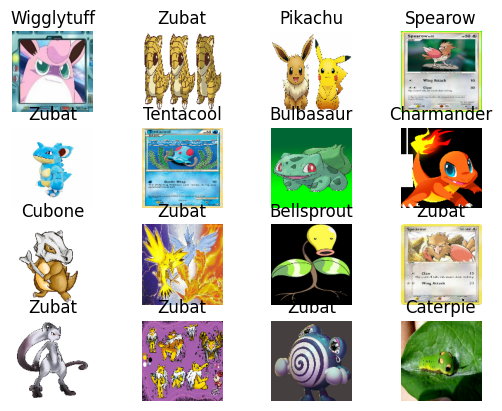

In [29]:
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



<h3>Preprocessing.</h3>

In [30]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.layers import Rescaling

# Rescale pixel values to [0, 1]
rescale = Rescaling(1./255)

# Apply the rescaling layer to your datasets
train = train.map(lambda x, y: (rescale(x), y))
val = val.map(lambda x, y: (rescale(x), y))

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),       # Randomly flip images horizontally
    RandomRotation(0.2),            # Randomly rotate images by up to 20%

])

# Apply augmentation to training dataset only
train = train.map(lambda x, y: (data_augmentation(x, training=True), y))

train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [31]:
#checking images
plt.Figure(figsize=(18,10))
num_row = 4
num_col = 4
for image,label in train.take(1):
    for i in range(num_row*num_col):
        ax = plt.subplot(num_row,num_col,i+1)
        plt.imshow(image[i].numpy())
        truth_idx = label[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis('off')



KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the pre-trained ResNet50 model without the top classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

# Create a new model on top of the pre-trained base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.optimizers import Adam

# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train,
    validation_data = val,
    epochs = 50
)

In [ ]:
model.save('/content/model_frozen_update.keras')